<a href="https://colab.research.google.com/github/sg879/IIBProject/blob/main/Post_Test/Bayesian_Convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Variational Inference on Test Data

## Importing Packages

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
import numpy as np
import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, random, lax
from functools import partial
import jax
from scipy.stats import multivariate_normal
import jax.flatten_util
import jax.example_libraries.optimizers as jeo

In [6]:
from jax.config import config
config.update("jax_enable_x64", True)

## Load Test Data

In [7]:
testx = jnp.load('drive/MyDrive/Project/Test/Testx.npy').astype('f').flatten()
truef = jnp.load('drive/MyDrive/Project/Test/Truef.npy').flatten()
inw = jnp.load('drive/MyDrive/Project/Test/Inputwin.npy')
outw = jnp.load('drive/MyDrive/Project/Test/Outputwin.npy')
truen = jnp.load('drive/MyDrive/Project/Test/Noise.npy')
testy = jsc.signal.convolve(testx, truef)
testy += truen*jnp.ones(jnp.shape(testy))

In [8]:
t = jnp.shape(testx)[0]-1
n = jnp.shape(testy)[0] - t - 1
dt = inw/t
timex = jnp.linspace(0.0, t*dt, t+1)
timey = jnp.linspace(0.0, (n+t)*dt, t+n+1)
timef = jnp.linspace(0.0, n*dt, n+1)

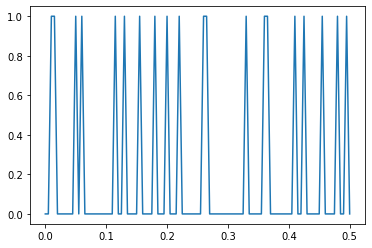

In [9]:
plt.plot(timex, testx)

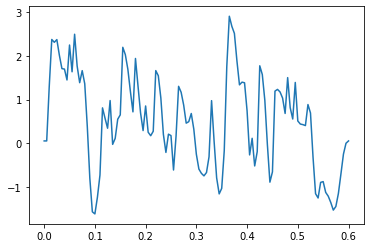

In [10]:
plt.plot(timey, testy)

## Function Definitions

### Lower Triangular Matrix **Cannot be jit-ed, so in-built in ELBO**

In [11]:
def Build_L(L_Array):

  L_Array_size = jnp.shape(L_Array)[0]

  M = jnp.round((-0.5 + jnp.sqrt(0.25 + 2*L_Array_size))).astype(jnp.integer)

  L_MM = jnp.zeros((M, M))

  return L_MM.at[jnp.tril_indices(M)].set(L_Array)

#### Lower Triangular Matrix Test

In [12]:
test_m = 10
test_triangle_size = jnp.round(test_m*(test_m + 1)/2).astype(jnp.integer)
test_eye = jnp.eye(test_m).at[jnp.tril_indices(test_m)].get()

In [13]:
print(Build_L(5*jnp.ones((test_triangle_size,))))

[[5. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 5. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 5. 5. 0. 0. 0. 0. 0. 0. 0.]
 [5. 5. 5. 5. 0. 0. 0. 0. 0. 0.]
 [5. 5. 5. 5. 5. 0. 0. 0. 0. 0.]
 [5. 5. 5. 5. 5. 5. 0. 0. 0. 0.]
 [5. 5. 5. 5. 5. 5. 5. 0. 0. 0.]
 [5. 5. 5. 5. 5. 5. 5. 5. 0. 0.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 0.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]]


In [14]:
print(Build_L(test_eye))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


### SE Prior

#### SE Covariance Function

In [15]:
@jit
def Squared_exp(I, J, Sigma_f, Ell):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2*Ell**2.0))

In [16]:
Vec_SE = jit(vmap(vmap(Squared_exp, in_axes=[None,0,None,None]),in_axes=[0,None,None,None]))

##### SE Test

In [17]:
testSEx = jnp.asarray([0.0, 0.3, 0.6, 0.9])

In [18]:
testSEy = jnp.asarray([0.0, 0.3, 0.6])

In [19]:
print(testSEx)

[0.  0.3 0.6 0.9]


In [20]:
print(Vec_SE(testSEx, testSEx, 3.0, 0.2))

[[9.00000000e+00 2.92187221e+00 9.99809688e-02 3.60587677e-04]
 [2.92187221e+00 9.00000000e+00 2.92187221e+00 9.99809688e-02]
 [9.99809688e-02 2.92187221e+00 9.00000000e+00 2.92187221e+00]
 [3.60587677e-04 9.99809688e-02 2.92187221e+00 9.00000000e+00]]


In [21]:
print(Vec_SE(testSEx, testSEy, 3.0, 0.2))

[[9.00000000e+00 2.92187221e+00 9.99809688e-02]
 [2.92187221e+00 9.00000000e+00 2.92187221e+00]
 [9.99809688e-02 2.92187221e+00 9.00000000e+00]
 [3.60587677e-04 9.99809688e-02 2.92187221e+00]]


### Cholesky Decomposition

In [22]:
@jit
def Broke_Chol(Symmetric_Matrix):
  F_size = jnp.shape(Symmetric_Matrix)[0]
  return jnp.linalg.cholesky(Symmetric_Matrix + 10.0**(-6.0)*jnp.eye(F_size))

In [23]:
@jit
def Good_Chol(Symmetric_Matrix):
  return jnp.linalg.cholesky(Symmetric_Matrix)

#### Test Cholesky

In [24]:
print(Vec_SE(timex[:3], timex[:3], 100.0, 0.1))

[[10000.          9987.50780925  9950.12479193]
 [ 9987.50780925 10000.          9987.50780925]
 [ 9950.12479193  9987.50780925 10000.        ]]


In [25]:
print(Good_Chol(Vec_SE(timex[:3], timex[:3], 100.0, 0.1)))

[[100.           0.           0.        ]
 [ 99.87507809   4.99687663   0.        ]
 [ 99.50124792   9.96880786   0.35289133]]


In [26]:
print(jnp.linalg.cholesky(Vec_SE(timex[:3], timex[:3], 100.0, 0.1)))

[[100.           0.           0.        ]
 [ 99.87507809   4.99687663   0.        ]
 [ 99.50124792   9.96880786   0.35289133]]


In [27]:
print(Broke_Chol(Vec_SE(timex[:3], timex[:3], 100.0, 0.1)))

[[100.           0.           0.        ]
 [ 99.87507809   4.99687683   0.        ]
 [ 99.50124791   9.96880766   0.35289979]]


In [28]:
print(jnp.linalg.cholesky(Vec_SE(timex[:3], timex[:3], 100.0, 0.1)+10**(-6.0)*jnp.eye(3)))

[[100.           0.           0.        ]
 [ 99.87507809   4.99687683   0.        ]
 [ 99.50124791   9.96880766   0.35289979]]


### Variational Bound (ELBO)

#### KL Divergence

In [29]:
# Simpler sum of squares for norm (square rooting then squaring wasteful)

In [30]:
# squared norm

In [31]:
@jit
def Kl_Div(V_M, L_MM):
  M = jnp.shape(V_M)[0]
  return 0.5*(-jnp.sum(jnp.log(jnp.square(jnp.diag(L_MM)))) +
              jnp.linalg.norm(L_MM)**2 + jnp.linalg.norm(V_M)**2 - M)

##### KL Divergence Test **Not Carried Out**

In [32]:
test_m = 11
test_eye = jnp.eye(test_m).at[jnp.tril_indices(test_m)].get()
test_z_m = jnp.linspace(0.0, timef[-1], test_m)
test_v_m = jnp.exp(-75*test_z_m)
test_l_mm = Build_L(test_eye)

In [33]:
test_kl = Kl_Div(test_v_m, test_l_mm)

In [34]:
print(test_kl)

0.6436084144642731


#### Log-Likelihood

In [35]:
# sum of squares

In [36]:
@jit
def Loglikely(Sigma_n, F_Sample, Testx, Testy):

  # Convolve the x-data and the f-sample together
  Y_mean = jsc.signal.convolve(Testx, F_Sample)

  # Shape of output-data
  D = jnp.shape(Y_mean)[0]
  
  # Difference between y-data and the mean 
  Diff = Testy - Y_mean

  return 0.5*(-D*jnp.log(2*jnp.pi*Sigma_n**2) - 
              jnp.linalg.norm(Diff)**2/Sigma_n**2)

In [37]:
Vec_Loglikely = jit(vmap(Loglikely, in_axes = [None, 0, None, None]))

###### Log-Likelihood Test

In [38]:
print(jsc.stats.multivariate_normal.logpdf(testy, jnp.convolve(testx, truef), 0.05**2*jnp.eye(t+n+1)))

190.79204258226747


In [39]:
print(Loglikely(-0.05, truef, testx, testy))

190.7920425822675


In [40]:
print(Vec_Loglikely(-0.05, jnp.vstack((truef, truef)), testx, testy))

[190.79204258 190.79204258]


#### Expected Log-Likelihood

In [41]:
# length scale of same order as the time over which covariance matrix build
# then many eignevalues of matrix will be close to zero (think of "uniform" matrix)
#  

In [42]:
# 

In [43]:
#@partial(jit, static_argnums = (0,1))
def Exp_Loglikely(Number_f, M, Subkey, Sigma_f, Ell_f, Sigma_n, Z_M, V_M, L_MM, 
                  K_NN, Timex, Testx, Timey, Testy):
  
  # Get vector of filter times
  T = jnp.shape(Testx)[0] - 1
  N = jnp.shape(Testy)[0] - T - 1

  F_times = jnp.linspace(0.0, Timey[-1]-Timex[-1], N + 1)

  # Get the relevant matrices
  K_MN = Vec_SE(Z_M, F_times, Sigma_f, Ell_f)
  K_MM = Vec_SE(Z_M, Z_M, Sigma_f, Ell_f)
  C_MM = jnp.linalg.cholesky(K_MM + 1e-6*jnp.eye(M))
  B = jsc.linalg.solve_triangular(C_MM, K_MN, lower = True) # modifying inplace dangerous for grad

  # Build the mean vector and covariance matrix of q(f)
  Mu_q = V_M @ B
  V_q = K_NN + B.T @ (L_MM @ L_MM.T - jnp.eye(M)) @ B

  # Get the samples of f
  Sampled_fs = random.multivariate_normal(Subkey, Mu_q, V_q + 1e-6*jnp.eye(N + 1),
                                          shape = (Number_f,))

  # Get the mean log-likelihood with each of these fs
  Likelihoods = Vec_Loglikely(Sigma_n, Sampled_fs, Testx, Testy)

  return jnp.mean(Likelihoods)

##### Expected Log-Likelihood Test **Not Carried Out**

In [44]:
test_number_f = 10000
test_m = 11
test_key = random.PRNGKey(10)
test_eye = jnp.eye(test_m).at[jnp.tril_indices(test_m)].get()
test_sigma_f = 1.0
test_ell_f = 0.01
test_sigma_n = 0.05
test_z_m = jnp.linspace(0.0, timef[-1], test_m)
test_v_m = jnp.exp(-75*test_z_m)
test_l_mm = Build_L(test_eye)
test_k_nn = Vec_SE(timef, timef, test_sigma_f, test_ell_f)

In [45]:
test_likelihood = Exp_Loglikely(test_number_f, test_m, test_key, test_sigma_f, 
                                test_ell_f, test_sigma_n, test_z_m, test_v_m, 
                                test_l_mm, test_k_nn, timex, testx, timey, testy)

In [46]:
print(test_likelihood)

-137594.47619538652


In [47]:
print(Exp_Loglikely(test_number_f, test_m, test_key, -1.0, 
                                test_ell_f, test_sigma_n, test_z_m, test_v_m, 
                                test_l_mm, test_k_nn, timex, testx, timey, testy))

-137594.47619538652


#### ELBO

In [48]:
# Divide ELBO by number of time bins to normalise

In [49]:
# Parameterise L_MM to have a positive diagonal 

In [50]:
# jnp.tril and diagonal in two seperate parts so that diagonal is positive

In [51]:
@partial(jit, static_argnums = ((0,1)))
def ELBO(Number_f, M, Subkey, Sigma_f, Ell_f, Sigma_n, Z_M, V_M, L_Array, K_NN, 
         Timex, Testx, Timey, Testy):
  
  
  L_MM = jnp.zeros((M, M))

  L_MM = L_MM.at[jnp.tril_indices(M)].set(L_Array)

  Expected_Like = Exp_Loglikely(Number_f, M, Subkey, Sigma_f, Ell_f, Sigma_n, 
                                Z_M, V_M, L_MM, K_NN, Timex, Testx, Timey, Testy)
  
  KL_Divergence = Kl_Div(V_M, L_MM)

  return Expected_Like - KL_Divergence

##### ELBO Test

In [52]:
test_number_f = 10000
test_m = 11
test_key = random.PRNGKey(10)
test_sigma_f = 1.0
test_ell_f = 0.01
test_sigma_n = 0.05
test_z_m = jnp.linspace(0.0, timef[-1], test_m)
test_v_m = jnp.exp(-75*test_z_m)
test_l_array = jnp.eye(test_m).at[jnp.tril_indices(test_m)].get()
test_k_nn = Vec_SE(timef, timef, test_sigma_f, test_ell_f)

In [53]:
test_elbo = ELBO(test_number_f, test_m, test_key, test_sigma_f, test_ell_f, 
                 test_sigma_n, test_z_m, test_v_m, test_l_array, test_k_nn, timex, 
                 testx, timey, testy)

In [54]:
print(test_elbo)

-137595.11980380098


In [55]:
print(test_likelihood - test_kl)

-137595.11980380098


### Gradient Ascent Functions

#### Jax Optimizers

##### ELBO for JAX ADAM

In [56]:
@partial(jit, static_argnums = (0,1))
def Exp_Loglikely2(Number_f, M, Sigma_f, Ell_f, Sigma_n, Z_M, V_M, L_MM, 
                  K_NN, Timex, Testx, Timey, Testy):
  
  Subkey = random.PRNGKey(10)
  
  # Get vector of filter times
  Dt = Timex[1]
  T = jnp.shape(Testx)[0] - 1
  N = jnp.shape(Testy)[0] - T - 1

  F_times = jnp.linspace(0.0, Timey[-1]-Timex[-1], N + 1)

  # Get the relevant matrices
  K_MN = Vec_SE(Z_M, F_times, Sigma_f, Ell_f)
  K_MM = Vec_SE(Z_M, Z_M, Sigma_f, Ell_f)
  C_MM = jnp.linalg.cholesky(K_MM + 1e-6*jnp.eye(M)) # Tried with I
  B = jsc.linalg.solve_triangular(C_MM, K_MN, lower = True)

  # Build the mean vector and covariance matrix of q(f)
  Mu_q = V_M @ B
  V_q = K_NN + B.T @ (L_MM @ L_MM.T - jnp.eye(M)) @ B

  # Get the samples of f
  #Sampled_fs = Mu_q + random.normal(Subkey, shape=(Number_f,)) @ jnp.linalg.cholesky(V_q) 
  Sampled_fs = random.multivariate_normal(Subkey, Mu_q, V_q + 1e-6*jnp.eye(N + 1),
                                          shape = (Number_f,))

  # Get the mean log-likelihood with each of these fs
  Likelihoods = Vec_Loglikely(Sigma_n, Sampled_fs, Testx, Testy)

  return jnp.mean(Likelihoods)

In [57]:
@partial(jit, static_argnums = ((0,1)))
def ELBO2(Number_f, M, Sigma_f, Ell_f, Sigma_n, Z_M, V_M, L_Array, K_NN, 
         Timex, Testx, Timey, Testy):
  
  #Number_f = np.asarray(Number_f, dtype = jnp.integer)
  #M = np.asarray(M, dtype = jnp.integer)
  Z_M = jnp.abs(Z_M)

  Z_M = jnp.sort(Z_M)
  
  L_MM = jnp.zeros((M, M))

  L_MM = L_MM.at[jnp.tril_indices(M)].set(L_Array)
  L_MM = L_MM.at[jnp.diag_indices(M)].set(jnp.abs(jnp.diag(L_MM)))

  Expected_Like = Exp_Loglikely2(Number_f, M, Sigma_f, Ell_f, Sigma_n, 
                                Z_M, V_M, L_MM, K_NN, Timex, Testx, Timey, Testy)
  
  KL_Divergence = Kl_Div(V_M, L_MM)

  return KL_Divergence - Expected_Like

##### Test Jax ADAM

In [58]:
# Bounding parameters

In [73]:
test_number_f = 30000
test_m = 11
test_key = random.PRNGKey(10)
_, *test_keys = random.split(random.PRNGKey(1), 3)
test_sigma_f = 1.5
test_ell_f = 0.007
test_sigma_n = 0.075
test_z_m = jnp.linspace(0.08, timef[-1]-0.01, int(test_m))
test_k_mm = Vec_SE(test_z_m, test_z_m, test_sigma_f, test_ell_f)
test_c = jnp.linalg.cholesky(test_k_mm)
#test_v_m = jsc.linalg.solve_triangular(test_c, truef[0::2], lower = True)
#test_v_m = jnp.exp(-75*test_z_m)
test_v_m = 0.1*random.normal(test_keys[0], shape = jnp.shape(test_z_m))
test_l_array = (jnp.eye(int(test_m))+jnp.diag(0.1*random.normal(test_keys[1], 
                                                                shape = (int(test_m),)))).at[jnp.tril_indices(int(test_m))].get()
test_k_nn = Vec_SE(timef, timef, test_sigma_f, test_ell_f)
test_parameters = (test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m,
                   test_l_array)
test_allparameters = (test_number_f, test_m, test_sigma_f, test_ell_f,
                      test_sigma_n, test_z_m, test_v_m, test_l_array, test_k_nn,
                      timex, testx, timey, testy)
test_keyzero = jnp.zeros(jnp.shape(test_key))
test_knnzero = jnp.zeros(jnp.shape(test_k_nn))
test_timexzero = jnp.zeros(jnp.shape(timex))
test_testxzero = jnp.zeros(jnp.shape(testx))
test_timeyzero = jnp.zeros(jnp.shape(timey))
test_testyzero = jnp.zeros(jnp.shape(testy))

In [64]:
print(jnp.shape(np.diag(0.1*random.normal(test_keys[1], shape = (int(test_m),)))))

(11, 11)


In [ ]:
print(test_k_nn)

In [75]:
test_gradient_func = jit(grad(ELBO2, argnums = (2,3,4,5,6,7)),
                         static_argnums = ((0,1)))

In [76]:
print(ELBO2(test_number_f, test_m, test_sigma_f, test_ell_f, 
                 test_sigma_n, test_z_m, test_v_m, test_l_array, test_k_nn, timex, 
                 testx, timey, testy))

122579.71328131882


In [77]:
print(ELBO(test_number_f, test_m, test_key, test_sigma_f, test_ell_f, 
                 test_sigma_n, test_z_m, test_v_m, test_l_array, test_k_nn, timex, 
                 testx, timey, testy))

-122579.71328131882


In [78]:
test_opt = jeo.adam(1e-3)
opt_init = test_opt[0]
opt_update = test_opt[1]
opt_getvals = test_opt[2]
test_state = opt_init(test_allparameters)
test_params_less1 = opt_getvals(test_state)

In [ ]:
print(test_allparameters)

In [ ]:
print(test_state)

In [ ]:
print((test_number_f, test_m, test_key, *test_gradient_func(*opt_getvals(test_state)), test_k_nn, timex, testx, 
            timey, testy))

In [ ]:
for i in range(1, 1000):
  test_params = opt_getvals(test_state)

  # Error catching
  if jnp.isnan(jax.flatten_util.ravel_pytree(test_params)[0]).any():
    test_failed = test_params_less1
  else:
    test_params_less1 = test_params

  Parameters_updated = [*test_params[2:8]]

  # Print grad()'d parameters
  print(f"The prior variance is:  {Parameters_updated[0]:.2f}")
  print(f"The prior lenth scale is:  {Parameters_updated[1]:.2f}")
  print(f"The noise is:  {Parameters_updated[2]:.2f}")
  print(f"The inducing points are:  {Parameters_updated[3]}")
  print(f"The parameterised mean of the inducing variables is:  {Parameters_updated[4]}")
  print(f"The lower triangle values for the inducing variables covariance is:  {Parameters_updated[5]}")
  print("\n\n\n")

  test_params = (test_number_f, test_m, *test_params[2:8], test_k_nn, 
                 timex, testx, timey, testy)
  test_g = test_gradient_func(*test_params)
  test_g = (0.0, 0.0,*test_g, test_knnzero, test_timexzero, test_testxzero, 
            test_timeyzero, test_testyzero)
  
  test_state = opt_update(i, test_g, test_state)

The prior variance is:  1.50
The prior lenth scale is:  0.01
The noise is:  0.07
The inducing points are:  [0.08  0.081 0.082 0.083 0.084 0.085 0.086 0.087 0.088 0.089 0.09 ]
The parameterised mean of the inducing variables is:  [ 0.03848595 -0.05932952  0.02131647  0.04566236  0.02414246  0.02594163
 -0.02279581  0.22712179 -0.06215035  0.05152061 -0.05092959]
The lower triangle values for the inducing variables covariance is:  [0.98417749 0.         1.09425521 0.         0.         0.95572292
 0.         0.         0.         1.05863674 0.         0.
 0.         0.         0.90511795 0.         0.         0.
 0.         0.         1.05583137 0.         0.         0.
 0.         0.         0.         0.97094498 0.         0.
 0.         0.         0.         0.         0.         1.14100825
 0.         0.         0.         0.         0.         0.
 0.         0.         0.91833792 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.98830109 0.      

In [ ]:
test_params_final = opt_getvals(test_state)

In [78]:
print(test_failed[2:8])

(DeviceArray(1.49121452, dtype=float64), DeviceArray(0.01257449, dtype=float64), DeviceArray(0.08785124, dtype=float64), DeviceArray([-3.27807572e-07,  4.91546211e-03,  3.84826566e-02,
              2.41433695e-02,  5.44058067e-02,  5.16657577e-02,
              5.30790447e-02,  6.82305698e-02,  7.14750699e-02,
              8.70345585e-02,  8.40615949e-02], dtype=float64), DeviceArray([ 0.05144119, -0.04579693,  0.03459636,  0.05315534,
              0.03589148,  0.01649649, -0.02958559,  0.21401895,
             -0.07313425,  0.03854997, -0.04656974], dtype=float64), DeviceArray([ 1.14016723,  0.09854701,  1.09488531, -0.01042175,
              0.13603184,  0.86568147,  0.09462739, -0.20874647,
              0.09052134,  0.93434206, -0.03545662, -0.21462839,
             -0.06962416, -0.063299  ,  0.98001114,  0.06408586,
              0.04214317, -0.07698288, -0.08157906,  0.04385831,
              0.99458178, -0.07812606,  0.12648146,  0.03477533,
              0.10353634,  0.12197

In [80]:
print(np.linalg.cholesky(Build_L(test_failed[7])))

[[ 1.06778613  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.09229096  1.04228964  0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [-0.00976014  0.13137673  0.92104634  0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.08862017 -0.20812383  0.12890656  0.93088995  0.          0.
   0.          0.          0.          0.          0.        ]
 [-0.03320573 -0.20297986 -0.04699158 -0.10371121  0.96163583  0.
   0.          0.          0.          0.          0.        ]
 [ 0.06001751  0.03511893 -0.08795531 -0.07331771  0.04288801  0.98731724
   0.          0.          0.          0.          0.        ]
 [-0.07316639  0.12782824  0.01874776  0.14417144  0.16775863 -0.02823981
   0.93682339  0.          0.          0.          0.        ]
 [-0.15626483 -0.08666671 -0.07871026 -0.15307902  0.05189781 -0.24521339
  -0.12

In [2]:
#@partial(jit, static_argnums = (0,1))
def Exp_Loglikely3(Number_f, M, Sigma_f, Ell_f, Sigma_n, Z_M, V_M, L_MM, 
                  K_NN, Timex, Testx, Timey, Testy):
  
  Subkey = random.PRNGKey(10)
  
  # Get vector of filter times
  Dt = Timex[1]
  T = jnp.shape(Testx)[0] - 1
  N = jnp.shape(Testy)[0] - T - 1

  F_times = jnp.linspace(0.0, Timey[-1]-Timex[-1], N + 1)

  # Get the relevant matrices
  K_MN = Vec_SE(Z_M, F_times, Sigma_f, Ell_f)
  K_MM = Vec_SE(Z_M, Z_M, Sigma_f, Ell_f)
  C_MM = jnp.linalg.cholesky(K_MM + 1e-6*jnp.eye(M)) 
  B = jsc.linalg.solve_triangular(C_MM, K_MN, lower = True)

  # Build the mean vector and covariance matrix of q(f)
  Mu_q = V_M @ B
  V_q = K_NN + B.T @ (L_MM @ L_MM.T - jnp.eye(M)) @ B

  # Get the samples of f
  Sampled_fs = random.multivariate_normal(Subkey, Mu_q, V_q + 1e-6*jnp.eye(N + 1),
                                          shape = (Number_f,))

  # Get the mean log-likelihood with each of these fs
  Likelihoods = Vec_Loglikely(Sigma_n, Sampled_fs, Testx, Testy)

  return V_q, jnp.mean(Likelihoods)


In [3]:
#@partial(jit, static_argnums = ((0,1)))
def ELBO3(Number_f, M, Sigma_f, Ell_f, Sigma_n, Z_M, V_M, L_Array, K_NN, 
         Timex, Testx, Timey, Testy):
  
  Number_f = np.asarray(Number_f, dtype = jnp.integer)
  M = np.asarray(M, dtype = jnp.integer)
  #Z_M = jnp.sqrt(jnp.square(Z_M))
  
  L_MM = jnp.zeros((M, M))

  L_MM = L_MM.at[jnp.tril_indices(M)].set(L_Array)

  Expected_Like = Exp_Loglikely2(Number_f, M, Sigma_f, Ell_f, Sigma_n, 
                                Z_M, V_M, L_MM, K_NN, Timex, Testx, Timey, Testy)
  
  KL_Divergence = Kl_Div(V_M, L_MM)

  print(KL_Divergence - Expected_Like[1])

  return Expected_Like# KL_Divergence - 

In [4]:
print(Exp_Loglikely3(test_number_f, test_m, *test_failed[2:8], test_k_nn, timex, testx, timey, testy)[0]) #+ 1e-1*np.eye(np.shape(test_k_nn)[0])))

NameError: ignored

In [ ]:
test_gradient_func(test_number_f, test_m, *test_failed[2:8], test_k_nn, timex, testx, timey, testy)

(DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float64),
 DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float64),
 DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan], dtype=float64))

In [ ]:
test_arr = [ELBO2(i, test_m, *fail_params, test_k_nn, timex, testx, timey, testy) for i in jnp.linspace(100, 200000, 200)]

In [ ]:
plt.plot(jnp.linspace(100, 200000, 200), test_arr)

##### Test Jax SGD

In [ ]:
test_number_f = 30000
test_m = 11
test_key = random.PRNGKey(10)
_, *test_keys = random.split(random.PRNGKey(1), 3)
test_sigma_f = 1.5
test_ell_f = 0.015
test_sigma_n = 0.075
test_z_m = jnp.linspace(0.01, timef[-1]-0.01, int(test_m))
test_k_mm = Vec_SE(test_z_m, test_z_m, test_sigma_f, test_ell_f)
test_c = jnp.linalg.cholesky(test_k_mm)
#test_v_m = jsc.linalg.solve_triangular(test_c, truef[0::2], lower = True)
#test_v_m = jnp.exp(-75*test_z_m)
test_v_m = 0.1*random.normal(test_keys[0], shape = jnp.shape(test_z_m))
test_l_array = jnp.eye(int(test_m)).at[jnp.tril_indices(int(test_m))].get() + \
                0.1*random.normal(test_keys[1], shape = (int(test_m*(test_m+1)/2),))
test_k_nn = Vec_SE(timef, timef, test_sigma_f, test_ell_f)
test_parameters = (test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m,
                   test_l_array)
test_allparameters = (test_number_f, test_m, test_sigma_f, test_ell_f,
                      test_sigma_n, test_z_m, test_v_m, test_l_array, test_k_nn,
                      timex, testx, timey, testy)
test_gradient_func = jit(grad(ELBO, argnums = (2,3,4,5,6,7)),
                         static_argnums = ((0,1)))
test_keyzero = jnp.zeros(jnp.shape(test_key))
test_knnzero = jnp.zeros(jnp.shape(test_k_nn))
test_timexzero = jnp.zeros(jnp.shape(timex))
test_testxzero = jnp.zeros(jnp.shape(testx))
test_timeyzero = jnp.zeros(jnp.shape(timey))
test_testyzero = jnp.zeros(jnp.shape(testy))

In [ ]:
test_gradient_func = jit(grad(ELBO2, argnums = (2,3,4,5,6,7)),
                         static_argnums = ((0,1)))

In [ ]:
test_opt = jeo.sgd(1e-5)
opt_init = test_opt[0]
opt_update = test_opt[1]
opt_getvals = test_opt[2]
test_state = opt_init(test_allparameters)
test_params_less1 = opt_getvals(test_state)

In [ ]:
for i in range(1, 100):
  test_params = opt_getvals(test_state)

  # Error catching
  if jnp.isnan(jax.flatten_util.ravel_pytree(test_params)[0]).any():
    test_failed = test_params_less1
  else:
    test_params_less1 = test_params

  Parameters_updated = [*test_params[2:8]]

  # Print grad()'d parameters
  print(f"The prior variance is:  {Parameters_updated[0]:.2f}")
  print(f"The prior lenth scale is:  {Parameters_updated[1]:.2f}")
  print(f"The noise is:  {Parameters_updated[2]:.2f}")
  print(f"The inducing points are:  {Parameters_updated[3]}")
  print(f"The parameterised mean of the inducing variables is:  {Parameters_updated[4]}")
  print(f"The lower triangle values for the inducing variables covariance is:  {Parameters_updated[5]}")
  print("\n\n\n")

  test_params = (test_number_f, test_m, *test_params[2:8], test_k_nn, 
                 timex, testx, timey, testy)
  test_g = test_gradient_func(*test_params)
  test_g = (0.0, 0.0,*test_g, test_knnzero, test_timexzero, test_testxzero, 
            test_timeyzero, test_testyzero)
  
  test_state = opt_update(i, test_g, test_state)

The prior variance is:  1.50
The prior lenth scale is:  0.01
The noise is:  0.07
The inducing points are:  [0.01  0.018 0.026 0.034 0.042 0.05  0.058 0.066 0.074 0.082 0.09 ]
The parameterised mean of the inducing variables is:  [ 0.03848595 -0.05932952  0.02131647  0.04566236  0.02414246  0.02594163
 -0.02279581  0.22712179 -0.06215035  0.05152061 -0.05092959]
The lower triangle values for the inducing variables covariance is:  [ 1.15280954  0.11149213  1.10804446  0.00260648  0.14944138  0.87918828
  0.10059591 -0.20459794  0.09614703  0.94667285 -0.02255622 -0.20131479
 -0.05629271 -0.06030353  0.99340864  0.07639715  0.05501165 -0.06453013
 -0.07816741  0.05648645  1.00749337 -0.06988712  0.13427207  0.04378227
  0.11337244  0.13069363 -0.02498881  0.96145369 -0.15407672 -0.09146538
 -0.06912443 -0.14502461  0.10556238 -0.22194533 -0.12008149  1.10100602
  0.08684733 -0.13273989  0.00398881  0.06242874 -0.06509256 -0.01311262
  0.04638682  0.16396883  0.98895308 -0.02354126 -0.1405

#### Update Parameters

In [ ]:
@jit
def Update(Step_t, Parameters, Step):
  # Update parameters
  Next_Parameters = jax.tree_multimap(
      lambda Dummy_Parameter, Dummy_Step: Dummy_Parameter + Step_t * Dummy_Step,
      Parameters, Step
  )
  return Next_Parameters

##### Test Update Parameters

In [ ]:
test_number_f = 10000
test_m = 11
test_key = random.PRNGKey(10)
test_sigma_f = 1.0 
test_ell_f = 0.01
test_sigma_n = 0.05
test_z_m = jnp.linspace(0.0, timef[-1], test_m)
test_k_mm = Vec_SE(test_z_m, test_z_m, test_sigma_f, test_ell_f)
test_c = jnp.linalg.cholesky(test_k_mm)
test_v_m = jsc.linalg.solve_triangular(test_c, truef[0::2], lower = True)
test_l_array = jnp.eye(test_m).at[jnp.tril_indices(test_m)].get()
test_k_nn = Vec_SE(timef, timef, test_sigma_f, test_ell_f)
test_parameters = (test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m,
                   test_l_array)
test_grad_elbo = jit(grad(ELBO, argnums = (3, 4, 5, 6, 7, 8)), 
                     static_argnums = ((0,1)))
test_step = test_grad_elbo(test_number_f, test_m, test_key, test_sigma_f, 
                           test_ell_f, test_sigma_n, test_z_m, test_v_m, 
                           test_l_array, test_k_nn, timex, testx, timey, testy)

In [ ]:
plt.plot(test_z_m, test_c @ test_v_m)

In [ ]:
print(test_parameters)

In [ ]:
print(test_step)

In [ ]:
test_next_parameters = Update(1.0, test_parameters, test_step)

In [ ]:
print(test_next_parameters)

#### 2-Norm of Gradient

In [ ]:
def Grad_Norm(Step):

  Step_Array = jnp.asarray(jax.flatten_util.ravel_pytree(test_parameters)[0])

  return jnp.sum(jnp.square(Step_Array))

##### Test 2-Norm of Gradient **Not Carried Out**

In [ ]:
test_number_f = 10000
test_m = 11
test_key = random.PRNGKey(10)
test_sigma_f = 1.0 
test_ell_f = 0.01
test_sigma_n = 0.05
test_z_m = jnp.linspace(0.0, timef[-1], test_m)
test_k_mm = Vec_SE(test_z_m, test_z_m, test_sigma_f, test_ell_f)
test_c = jnp.linalg.cholesky(test_k_mm)
test_v_m = jsc.linalg.solve_triangular(test_c, truef[0::2], lower = True)
test_l_array = jnp.eye(test_m).at[jnp.tril_indices(test_m)].get()
test_k_nn = Vec_SE(timef, timef, test_sigma_f, test_ell_f)
test_parameters = (test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m,
                   test_l_array)
test_grad_elbo = jit(grad(ELBO, argnums = (3, 4, 5, 6, 7, 8)), 
                     static_argnums = ((0,1)))
test_step = test_grad_elbo(test_number_f, test_m, test_key, test_sigma_f, 
                           test_ell_f, test_sigma_n, test_z_m, test_v_m, 
                           test_l_array, test_k_nn, timex, testx, timey, testy)

In [ ]:
# "Perfect" Norm
test_norm = Grad_Norm(test_step)

In [ ]:
print(test_norm)

#### Backtracking Line Search

##### Conditional Function

In [ ]:
def Back_Cond():

  Left_side = ELBO(Number_f, M, Subkey, *New_Parameters, K_NN, Timex, Testx,
                  Timey, Testy)

  Right_side =  Current_ELBO + Alpha * Step_t * Step_Norm

##### Backtrack

In [ ]:
def Back_Track(Alpha, Beta, Number_f, M, Subkey, Parameters, K_NN, Timex, Testx, 
               Timey, Testy):

  Step_t = 1e-2

  Gradient_ELBO = jit(grad(ELBO, argnums = (3, 4, 5, 6, 7, 8)),
                      static_argnums = ((0,1)))
  
  Step = Gradient_ELBO(Number_f, M, Subkey, *Parameters, K_NN, Timex, Testx,
                       Timey, Testy)
  
  Step_Norm = Grad_Norm(Step)
  
  Current_ELBO = ELBO(Number_f, M, Subkey, *Parameters, K_NN, Timex, Testx,
                      Timey, Testy)

  Iteratee = [Step_t, ]

  Iteratee = lax.while_loop(a)
  New_Parameters = Update(Step_t, Parameters, Gradient_ELBO)

  Left_side = ELBO(Number_f, M, Subkey, *New_Parameters, K_NN, Timex, Testx,
                  Timey, Testy)

  Right_side =  Current_ELBO + Alpha * Step_t * Step_Norm






#### Gradient Ascent

In [ ]:
def Grad_Ascent():

  # Get Parameters

  # While norm(Grad(ELBO(Parameters)))<Epsilon:

  #     Backtrack to find next Params

  #     Grad(ELBO(New Parameters))


